In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

sns.set('notebook', font_scale=1.6, palette='Set2')

В этой задаче рассмотрим и сравним две стратегии поиска оптимальных значений некоторого функционала: GridSearch и RandomSearch. В реальной жизни значение функционала &mdash; это значение целевой метрики качества, а оптимизация идет по гиперпараметрам некоторой модели машинного обучения. Коротко напомним, в чем же заключается каждая стратегия.

* GridSearch &mdash; полный перебор по сетке. Суть перебора по сетке заключается в следующем: вы задаете область значений гиперпараметров, которые хотите оптимизировать, обучаете все модели, которые возможно получить в рамках заданного пространства поиска гиперпараметров. Затем выбираете из данных моделей ту, которая дала наилучшее качество на кросс-валидации.
* RandomSearch &mdash; это стратегия, при которой рассматривается некоторая выборка из множества значений гиперпараметров. По умолчанию часто используется равномерное распределение. Лучшая модель выбирается так же на основе кросс-валидации.

Разберем сначала **одномерный случай**. Для этого рассмотрим следующую функцию.

In [ ]:
def f(x):
    return 5.2 - 5/(1+(3*(x))**2) - np.cos(x)/5

Поcтроим график функции $f(x)$ на отрезке $[-20, 20]$. В чем его особенность?

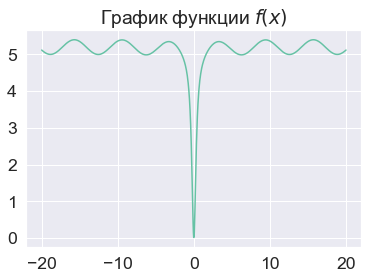

In [ ]:
grid = np.linspace(-20, 20, 1000)

plt.title('График функции $f(x)$')
plt.plot(grid, f(grid));

Какие проблемы могут возникнуть при поиске минимума этой функции, если используется поиск по сетке?

**Ответ:**

Из графика видно, что в окрестности точки ноль функция очень резко достигает своего минимума. Такой минимум искать будет сложно. Результаты сильно зависят от соотношения между границами сетки и ее шага. Например, если взять сетку от -10 до 10 из 11 точек, то мы в точности попадем в минимум. Но на практике, это будет скорее случайным совпадаением.

Рассмотрим **поиск по сетке** и проведем вычислительный эксперимент. Для этого будем генерировать случайное смещение из $U[-0.5, 0.5]$, а затем рассматривать смещенную на $x_0$ сетку размера $n$ на отрезке $[-10, 10]$, после чего поиском по сетке искать оптимальное значение $f$.

In [ ]:
# рассматриваемые размеры сеток
grid_size = np.arange(2, 1000)
n_experiments = 100  # количество экспериментов

In [ ]:
# массив для минимумов по сетке для текущего эксперимента
grid_min_f_trace = []

for _ in tqdm(range(n_experiments)):
    # случайное смещение сетки на [-0.5, 0.5]
    x_0 = sps.uniform.rvs() - 0.5
    # массив для минимумов для текущего размера сетки
    grid_f_min = []
    # цикл по размеру сетки
    for n in grid_size:
        # сетка на [-10, 10] размера n
        grid = np.linspace(-10, 10, n)
        # найденный по сетке со смещением x_0 минимум функции f
        f_min = f(grid - x_0).min()
        # сохраним минимум для сетки размера n
        grid_f_min.append(f_min)
    # сохраним минимумы текущего эксперимента
    grid_min_f_trace.append(grid_f_min)

  0%|          | 0/100 [00:00<?, ?it/s]

Для нескольких экспериментов построим графики значений минимума от количества точек в сетке.
Для большей наглядности и информативности сразу **зафиксируйте диапазон значений по оси y**, а также отобразим графики в **логарифмическом масштабе**.

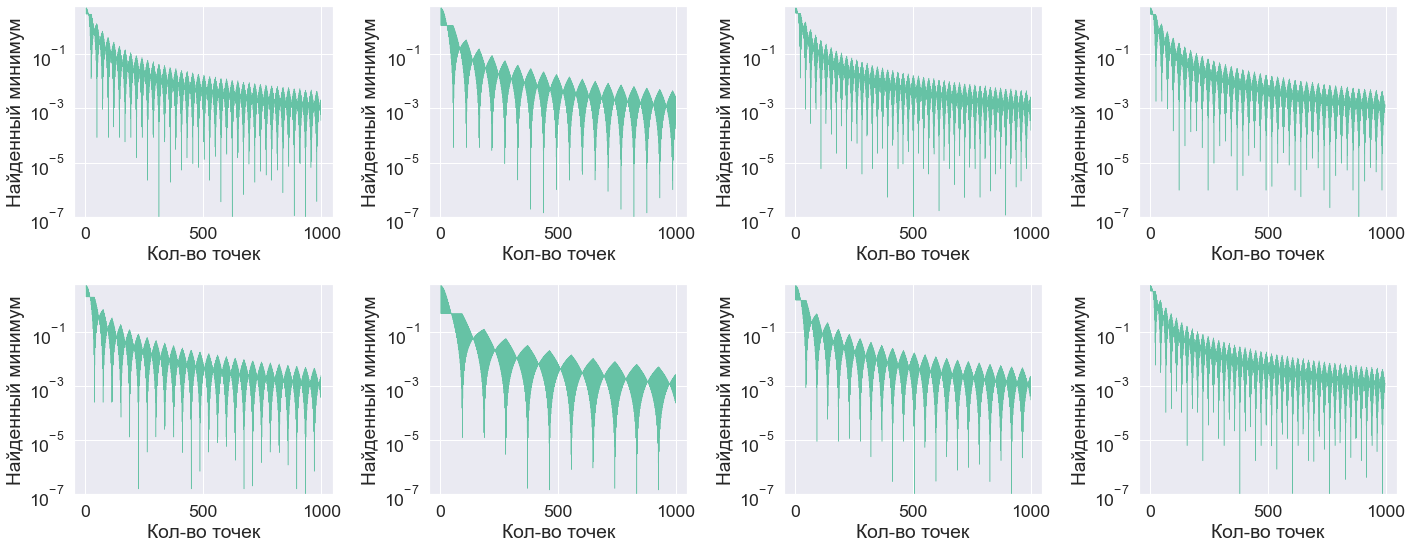

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(grid_size, grid_min_f_trace[i], lw=0.5)
    plt.xlabel('Кол-во точек')
    plt.ylabel('Найденный минимум')
    plt.ylim((1e-7, 6))
    plt.yscale('log')
plt.tight_layout()

Теперь рассмотрим **случайный поиск**

In [ ]:
# рассматриваемое количество случайных точек
random_size = np.arange(2, 1000)

In [ ]:
# массив для минимумов для текущего эксперимента
random_min_f_trace = []

# цикл по экспериментам
for _ in tqdm(range(n_experiments)):
    # случайное смещение на [-0.5, 0.5]
    x_0 = sps.uniform.rvs() - 0.5
    # массив для минимумов для текущего количества точек
    random_min_f = []
    # сгенерируем случайные на [-10, 10] точки сразу
    points = sps.uniform(-10, 20).rvs(size=random_size.max())

    #цикл по количеству точек
    for n in random_size:
        x = points[:n]
        # найденный по первым n случайным точкам со смещением x_0 минимум функции f
        f_min = f(x - x_0).min()
        # сохранение результатов
        random_min_f.append(f_min)

    random_min_f_trace.append(random_min_f)

  0%|          | 0/100 [00:00<?, ?it/s]

Снова для нескольких экспериментов построим графики значений минимума от количества точек при случайном поиске.

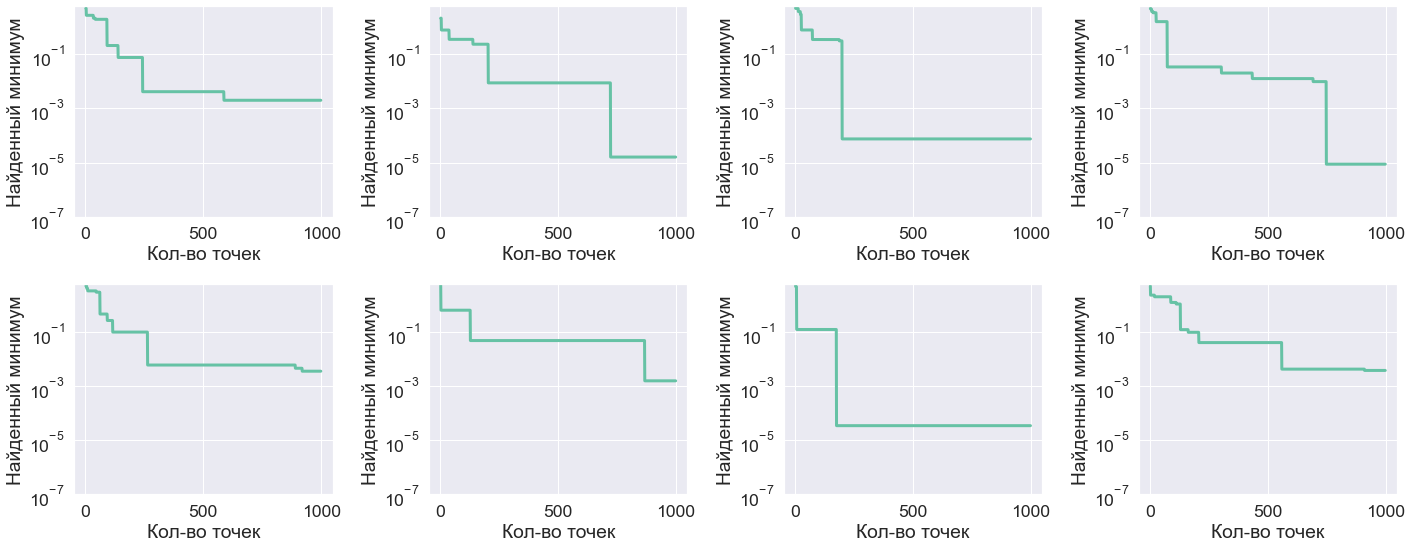

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(random_size, random_min_f_trace[i], lw=3)
    plt.xlabel('Кол-во точек')
    plt.ylabel('Найденный минимум')
    plt.ylim((1e-7, 6))
    plt.yscale('log')
plt.tight_layout()

Сравним два метода. Для этого построим график зависимости найденного минимума от количества точек (случайных или в сетке). Перед этим предварительно усредним результат по количеству экспериментов.

In [ ]:
# усредним по экспериментам
grid_min_f_mean = np.mean(grid_min_f_trace, axis=0)
random_min_f_mean = np.mean(random_min_f_trace, axis=0)

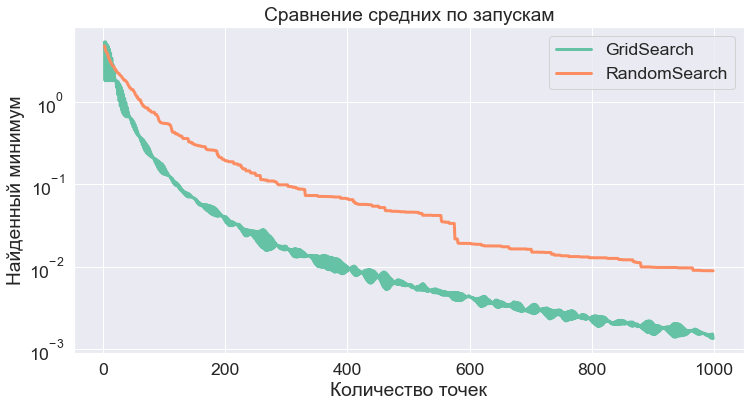

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Сравнение средних по запускам')

plt.plot(grid_size, grid_min_f_mean, lw=3, label='GridSearch')
plt.plot(grid_size, random_min_f_mean, lw=3, label='RandomSearch')

plt.xlabel('Количество точек')
plt.ylabel('Найденный минимум')
plt.legend()
plt.yscale('log')

**Вывод:** По проведенному эксперименту можно сделать вывод, что в данном случае поиск (**одномерном**) по сетке в среднем оказывается более эффективным, по сравнению со случайным поиском.

Теперь расмотрим **двумерный случай**, для этого определим следующую функцию:

In [ ]:
def f(x, y,):
    return 5.4 - 5/(1+(3*x)**2) - np.cos(x)/5 - np.cos(y)/5

Построим тепловую карту значений этой функции на $[-20, 20]^2$.

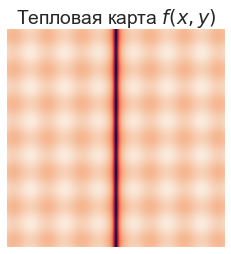

In [ ]:
x = np.linspace(-20, 20, n).reshape((1, -1))
y = x.T

plt.title('Тепловая карта $f(x,y)$')
plt.imshow(f(x, y))
plt.axis('off');

Проведем эксперимент, аналогичный одномерному случаю. В случае поиска по сетке рассмотрим сетку размера $n$ на $[-10, 10]$ по каждой координате. Таким образом, общий размер сетки будет $n^2$.

In [ ]:
# рассматриваемые размеры сеток
grid_size = np.arange(2, 500)

# массив для минимумов по сетке для текущего эксперимента
grid_min_f_trace = []

for _ in tqdm(range(n_experiments)):
    # случайное смещение сетки на [-0.5, 0.5]
    x_0 = sps.uniform.rvs() - 0.5
    y_0 = sps.uniform.rvs() - 0.5

    # массив для минимумов для текущего размера сетки
    grid_f_min = []
    # цикл по размеру сетки
    for n in grid_size:
        # сетка на [-10, 10] размера n по каждой оси
        x_grid = np.linspace(-10, 10, n).reshape((1, -1))
        y_grid = x_grid.T
        # найденный по сетке минимум функции f
        f_min = f(x_grid - x_0, y_grid - y_0).min()
        # сохраним минимум для сетки размера n
        grid_f_min.append(f_min)
    # сохраним минимумы текущего эксперимента
    grid_min_f_trace.append(grid_f_min)

  0%|          | 0/100 [00:00<?, ?it/s]

Изобразим несколько запусков.

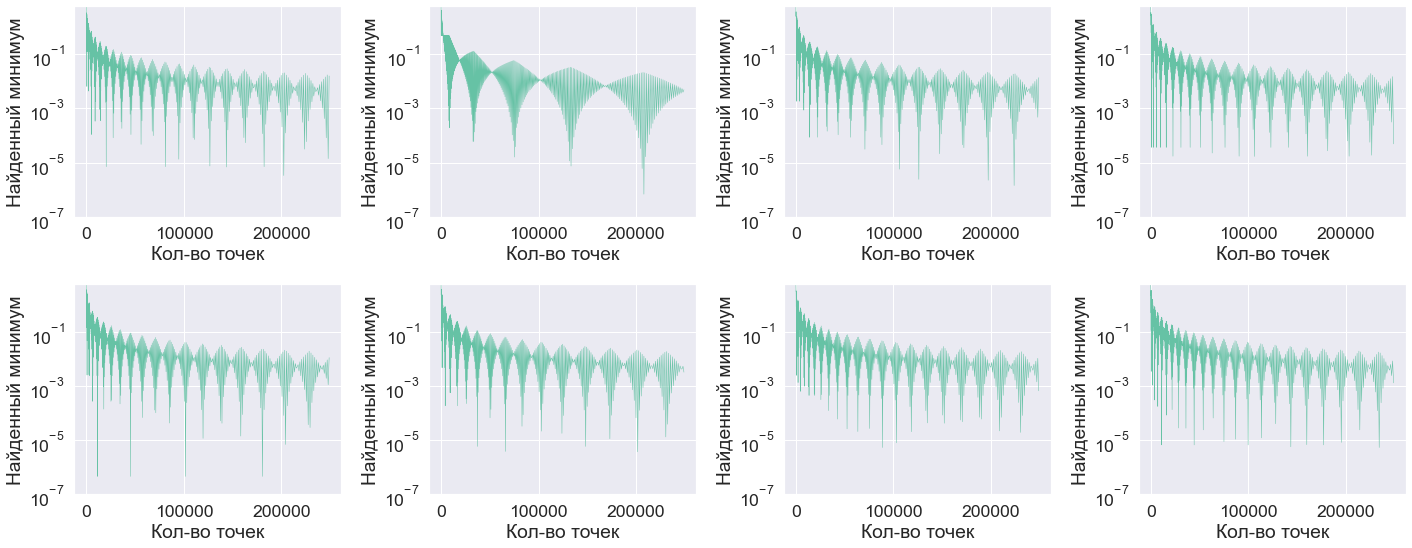

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(grid_size**2, grid_min_f_trace[i], lw=0.5)
    plt.xlabel('Кол-во точек')
    plt.ylabel('Найденный минимум')
    plt.ylim((1e-7, 6))
    plt.yscale('log')
plt.tight_layout()

In [ ]:
# рассматриваемое количество точек
random_size = np.arange(2, 250000)
# массив для минимумов для текущего эксперимента
random_min_f_trace = []

# цикл по экспериментам
for _ in tqdm(range(n_experiments)):
    # случайное смещение на [-0.5, 0.5]^2
    x_0 = sps.uniform.rvs() - 0.5
    y_0 = sps.uniform.rvs() - 0.5
    # массив для минимумов для текущего количества точек
    random_min_f = []
    # сгенерируем случайные на [-10, 10]^2 точки сразу
    points_x = sps.uniform(loc=-10, scale=20).rvs(size=random_size.max())
    points_y = sps.uniform(loc=-10, scale=20).rvs(size=random_size.max())

    #цикл по количеству точек
    for n in random_size[grid_size**2]:
        x = points_x[:n]
        y = points_y[:n]
        # найденный минимум функции f
        f_min = f(x - x_0, y - y_0).min()
        # сохранение результатов
        random_min_f.append(f_min)

    random_min_f_trace.append(random_min_f)

  0%|          | 0/100 [00:00<?, ?it/s]

Снова изобразим несколько запусков.

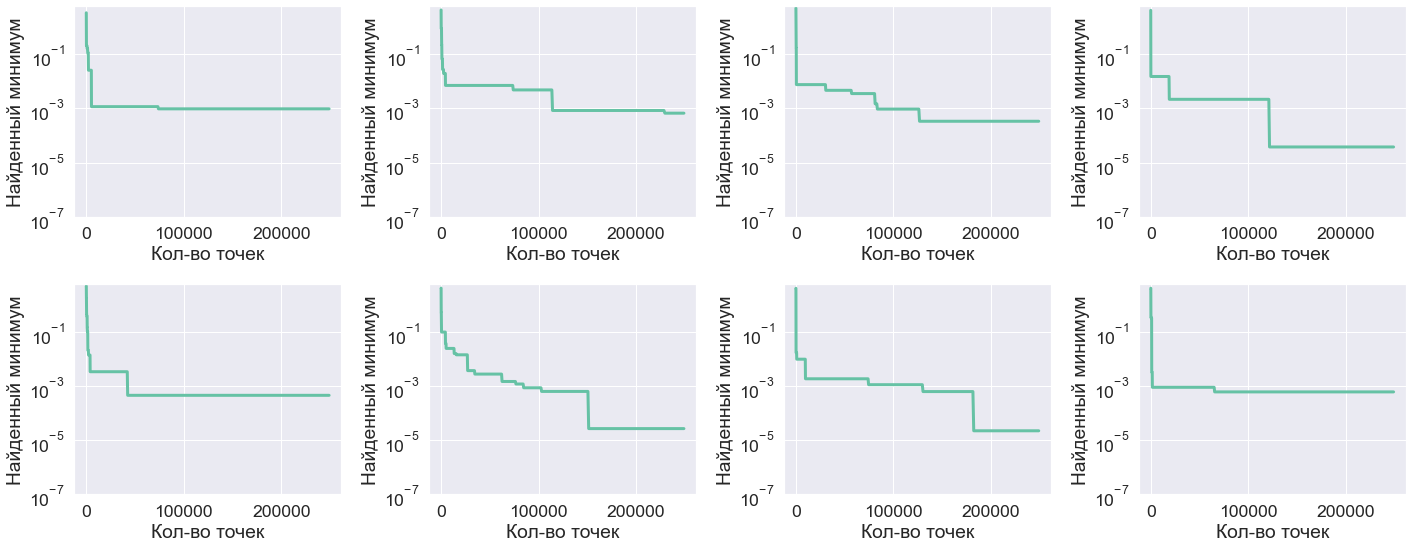

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(random_size[grid_size**2], random_min_f_trace[i], lw=3)
    plt.xlabel('Кол-во точек')
    plt.ylabel('Найденный минимум')
    plt.ylim((1e-7, 6))
    plt.yscale('log')
plt.tight_layout()

In [ ]:
grid_min_f_mean = np.mean(grid_min_f_trace, axis=0)
random_min_f_mean = np.mean(random_min_f_trace, axis=0)

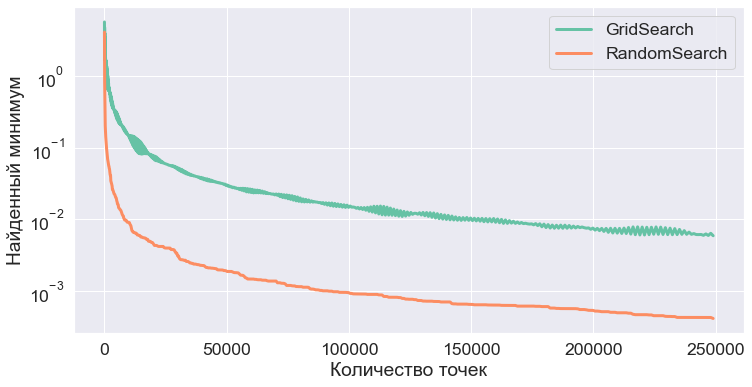

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(grid_size**2, grid_min_f_mean, lw=3, label='GridSearch')
plt.plot(random_size[grid_size**2], random_min_f_mean, lw=3, label='RandomSearch')
plt.xlabel('Количество точек')
plt.ylabel('Найденный минимум')
plt.legend()
plt.yscale('log')

**Вывод:**
* Во втором случае случайный поиск оказывается более эффективным, по сравнению с поиском по сетке.
* В реальной жизни, если гиперпараметров много и их пространство значений достаточно большое, то рекомендуется пользоваться случайным поиском.